# steps to counting over all of MAG as represented here...

+ identify subset to handle
+ gather publication years of papers
+ gather paper -> author dictionary
+ loop over citations, and do some counting! // just use paper IDs for everything
+ save a dictionary which maps from the IDs to something meaningful, for later lookup (Title, Year, Authors) {how big is this dictionary?}

In [1]:
from common_imports import *

In [2]:
class counter:

    def __init__(
            self,
            output_database, name_blacklist=[],
            RUN_EVERYTHING=True,
            groups=None, group_reps=None,
            citations_filter=None, journals_filter=None, debug=False,
            trimCounters=False, wos_type='csv'
    ):

        self.name_blacklist = name_blacklist
        self.debug = debug
        self.output_database = output_database
        self.groups = groups
        self.group_reps = group_reps

        self.wos_type = wos_type

        self.RUN_EVERYTHING = RUN_EVERYTHING
        self.citations_filter = citations_filter
        self.journals_filter = journals_filter
        self.trimCounters = trimCounters

        # Instantiating counters
        self.ind = defaultdict(lambda: defaultdict(int))
        self.track_doc = defaultdict(lambda: defaultdict(set))
        self.doc = defaultdict(lambda: defaultdict(int))

    def cnt(self, term, space, doc):
        if ".".join(sorted(space.split("."))) != space:
            raise Exception(space, "should be sorted...")

        if type(term) != tuple:
            term = tuple([term])

        # it's a set, yo
        self.track_doc[space][term].add(doc)
        # update cnt_doc
        self.doc[space][term] = len(self.track_doc[space][term])
        # update ind count
        self.ind[space][term] += 1

    def save_counters(self):
        db = Dataset(self.output_database)
        db.clear_all()

        db.save_variable('_attributes', {})

        for k, count in self.doc.items():
            varname = "doc ___ %s" % k
            db.save_variable(varname, dict(count))

        for k, count in self.ind.items():
            varname = "ind ___ %s" % k
            db.save_variable(varname, dict(count))

# step 0... reload the sociology papers identified

In [5]:
import pickle
with open('soc_papers.pickle', 'rb') as inf:
    socpapers = pickle.load(inf)

# step 1... go get pub years

In [6]:
def genlim(limit):
    def limiter(gen):
        for i,item in enumerate(gen):
            if i > limit:
                break
            yield item
    return limiter

In [8]:
# realizing I need info for EVERYTHING
# or, at least what was citing, + cited, at least 5 times...
# because I was considering all the cited, of sociologists.
# thinking of sociologists as the actors...
# my current dataset isn't going to be comparable...

In [9]:
infos = {}
#typs = categorical()
journals = categorical()

with Path(home,'datasets/s4/MAG/Papers.txt').open() as inf:
    for i,l in enumerate(inf):
        l = l.split('\t')
        if (i+1) % 1e7 == 0: # there are something like 100M papers!, i.e. 1e8
            print('Processed', f"{(i+1)//1e6:,}M", 'docs. Got', f"{len(infos):,}", 'papers\' info')
            
        my_id = int(l[0])
        
        if my_id not in socpapers:
            continue
        
        if l[7] == '': # saw this for some dataset... idk why. very rare
            continue
        
        if l[3] != 'Journal':
            continue
        
        year = int(l[7])
        #typ = typs[ l[3] ]
        journal = journals[ l[11] ]
        
        infos[my_id] = [year, journal]

Processed 10.0M docs. Got 88,062 papers' info
Processed 20.0M docs. Got 176,051 papers' info
Processed 30.0M docs. Got 264,550 papers' info
Processed 40.0M docs. Got 352,464 papers' info
Processed 50.0M docs. Got 440,556 papers' info
Processed 60.0M docs. Got 528,856 papers' info
Processed 70.0M docs. Got 616,949 papers' info
Processed 80.0M docs. Got 705,498 papers' info
Processed 90.0M docs. Got 793,453 papers' info
Processed 100.0M docs. Got 881,421 papers' info
Processed 110.0M docs. Got 969,083 papers' info
Processed 120.0M docs. Got 1,058,295 papers' info
Processed 130.0M docs. Got 1,146,779 papers' info
Processed 140.0M docs. Got 1,234,605 papers' info
Processed 150.0M docs. Got 1,322,931 papers' info
Processed 160.0M docs. Got 1,411,341 papers' info
Processed 170.0M docs. Got 1,499,565 papers' info
Processed 180.0M docs. Got 1,587,481 papers' info
Processed 190.0M docs. Got 1,674,865 papers' info
Processed 200.0M docs. Got 1,762,886 papers' info
Processed 210.0M docs. Got 1,851

In [11]:
with open('infos_citing.pickle', 'wb') as outf:
    pickle.dump( (infos, journals), outf)

# gather citations from these docs, to judge what extra info I need

In [14]:
cits = []
with Path(home, 'datasets/s4/MAG/PaperReferences.txt').open() as inf:
    for i,l in enumerate(inf):
        if (i+1)%1e7 == 0:
            print(f"Citation link {i+1:,}. Collected {len(cits):,} citations.")
            
        l = l[:-1] # strip the trailing \n from the line
        l = l.split('\t') # tab delimited
        l = list(map(int,l)) # map to integers. saving on memory this way hopefully
        
        if l[0] in infos:
            cits.append([l[0], l[1]])

Citation link 10,000,000. Collected 43,489 citations.
Citation link 20,000,000. Collected 86,145 citations.
Citation link 30,000,000. Collected 130,648 citations.
Citation link 40,000,000. Collected 172,844 citations.
Citation link 50,000,000. Collected 216,538 citations.
Citation link 60,000,000. Collected 298,175 citations.
Citation link 70,000,000. Collected 393,697 citations.
Citation link 80,000,000. Collected 458,035 citations.
Citation link 90,000,000. Collected 479,047 citations.
Citation link 100,000,000. Collected 549,275 citations.
Citation link 110,000,000. Collected 643,777 citations.
Citation link 120,000,000. Collected 738,918 citations.
Citation link 130,000,000. Collected 836,498 citations.
Citation link 140,000,000. Collected 927,998 citations.
Citation link 150,000,000. Collected 1,019,950 citations.
Citation link 160,000,000. Collected 1,112,978 citations.
Citation link 170,000,000. Collected 1,208,542 citations.
Citation link 180,000,000. Collected 1,300,100 citati

In [15]:
# only keep the cited that get at least 5 citations
ccits = Counter([x[1] for x in cits])
cited_to_keep = set([x for x,v in ccits.items() if v>=5])

In [17]:
with open('cited_to_keep.pickle', 'wb') as outf:
    pickle.dump( cited_to_keep, outf)

In [16]:
with open('cits.pickle', 'wb') as outf:
    pickle.dump( cits, outf)

# going to have to go back & get info for everyone now...

In [19]:
infos_new = {}
typs = categorical()
journals = categorical()

with Path(home,'datasets/s4/MAG/Papers.txt').open() as inf:
    for i,l in enumerate(inf):
        l = l.split('\t')
        if (i+1) % 1e7 == 0: # there are something like 100M papers!, i.e. 1e8
            print('Processed', f"{(i+1)//1e6:,}M", 'docs. Got', f"{len(infos_new):,}", 'papers\' info')
            
        my_id = int(l[0])
        
        if my_id not in socpapers and my_id not in cited_to_keep:
            continue
        
        if l[7] == '': # very rare. dataset.
            continue
        
        year = int(l[7])
        typ = typs[ l[3] ]
        journal = journals[ l[11] ]
        
        infos_new[my_id] = [year, typ, journal]

Processed 10.0M docs. Got 2,222,638 papers' info
Processed 20.0M docs. Got 2,222,638 papers' info
Processed 30.0M docs. Got 2,222,638 papers' info
Processed 40.0M docs. Got 2,222,638 papers' info
Processed 50.0M docs. Got 2,222,638 papers' info
Processed 60.0M docs. Got 2,222,638 papers' info
Processed 70.0M docs. Got 2,222,638 papers' info
Processed 80.0M docs. Got 2,222,638 papers' info
Processed 90.0M docs. Got 2,222,638 papers' info
Processed 100.0M docs. Got 2,222,638 papers' info
Processed 110.0M docs. Got 2,222,638 papers' info
Processed 120.0M docs. Got 2,222,638 papers' info
Processed 130.0M docs. Got 2,222,638 papers' info
Processed 140.0M docs. Got 2,222,638 papers' info
Processed 150.0M docs. Got 2,222,638 papers' info
Processed 160.0M docs. Got 2,222,638 papers' info
Processed 170.0M docs. Got 2,222,638 papers' info
Processed 180.0M docs. Got 2,222,638 papers' info
Processed 190.0M docs. Got 2,222,638 papers' info
Processed 200.0M docs. Got 2,222,638 papers' info
Processed

In [24]:
with open('infos_all.pickle', 'wb') as outf:
    pickle.dump( (infos_new, journals), outf)

# something else

In [61]:
# get the journal names...
jnames = {}

with Path(home,'datasets/s4/MAG/Journals.txt').open() as inf:
    for i,l in enumerate(inf):
        l = l.split('\t')
        
        ji = int(l[0])
        jnames[ji] = l[3]

In [10]:
typs.items

NameError: name 'typs' is not defined

In [38]:
typs['Journal']

2

In [39]:
if False:

    # get rid of everything except Journal articles...
    # hopefully this is effective

    socpapers_filt = set()
    for ii, (typ, year) in infos.items():
        if typ == typs['Journal']:
            socpapers_filt.add(ii)

In [40]:
len(socpapers_filt), len(socpapers)

(2222638, 4688396)

In [ ]:
authors = defaultdict(set)
fauthors = {}

with Path(home,'datasets/s4/MAG/PaperAuthorAffiliations.txt').open() as inf:
    for i,l in enumerate(inf):
        if (i+1)%1e7 == 0:
            print(f'Affiliation link {i+1:,}. Collected authors for {len(authors):,} out of {len(infos_new):,}.')
            
        l = l.split('\t')
        
        pi = int(l[0])
        ai = int(l[1])
        
        seq = int(l[3])
        
        if pi not in infos_new:
            continue
        
        authors[pi].add(ai)
        if seq == 0:
            fauthors[pi] = ai

Affiliation link 10,000,000. Collected authors for 98,110 out of 5,215,196.
Affiliation link 20,000,000. Collected authors for 200,709 out of 5,215,196.


(array([1.688969e+06, 3.309370e+05, 1.179740e+05, 4.515000e+04,
        0.000000e+00, 1.841300e+04, 9.294000e+03, 4.410000e+03,
        2.613000e+03, 1.434000e+03]),
 array([1. , 1.8, 2.6, 3.4, 4.2, 5. , 5.8, 6.6, 7.4, 8.2, 9. ]),
 <BarContainer object of 10 artists>)

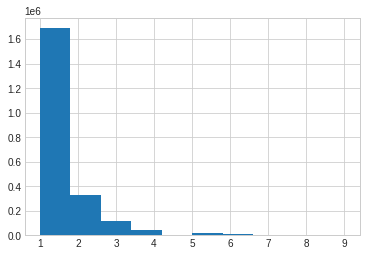

In [46]:
plt.hist( [len(v) for k,v in authors.items() if len(v) < 10] )

In [50]:
len(authors)

2222638

In [48]:
with open('authors.pickle', 'wb') as outf:
    pickle.dump(authors, outf)

In [62]:
len(infos)

4688383

In [63]:
len(fauthors)

NameError: name 'fauthors' is not defined

In [ ]:
with open('fauthors.pickle', 'wb') as outf:
    pickle.dump( fauthors, outf)

# first counting for all these works...

In [2]:
# this is where you create the dataset...
# perhaps need a better interface here?
dta = Dataset('testing')

Data file not found. Looking for entry in Harvard Dataverse...
No entry found in Harvard dataverse.


Create new folder with name `testing`?:  yes


loading variable testing/_attributes from disk
loading variable testing/groups from disk


In [84]:
c = counter('testing')

In [ ]:
with Path(home, 'datasets/s4/MAG/PaperReferences.txt').open() as inf:
    for i,l in enumerate(inf):
        if (i+1)%1e7 == 0:
            print(f"Citation link {i+1:,}. Collected {sum(c.ind['fy'].values()):,} citations.")
        
        l = l[:-1] # strip the trailing \n from the line
        l = l.split('\t') # tab delimited
        l = list(map(int,l)) # map to integers. saving on memory this way hopefully
        #print(l)
        
        citing, cited = l[0], l[1]
        if citing not in socpapers_filt or cited not in socpapers_filt: # interesting question, should I consider only citations to other soc papers?
            continue
            
        fy = infos[ citing ][1]
        ty = infos[ cited ][1]
        fj = infos[ citing ][2]
        tj = infos[ citing ][2]

        #c.cnt(doc.journal, 'fj', citing)
        c.cnt(fy, 'fy', citing)
        c.cnt(ty, 'ty', citing)
        c.cnt((cited, fy), 'c.fy', citing)
        c.cnt((cited, fj), 'c.fj', citing)

        c.cnt((fj, fy), 'fj.fy', citing)

        c.cnt(cited, 'c', citing)

        c.cnt((fy, ty), 'fy.ty', citing)
        c.cnt((fj, ty), 'fj.ty', citing)

        for a in authors[cited]:
            c.cnt(a, 'ta', citing)
            c.cnt((fy, a), 'fy.ta', citing)
            c.cnt((fj, a), 'fj.ta', citing)

        #c.cnt((cited, doc.journal, fy), 'c.fj.fy', citing)

        # first author!
        if False:
            ffa = fauthors[citing]
            c.cnt(ffa, 'ffa', citing)
            c.cnt((ffa, fy), 'ffa.fy', citing)
            c.cnt((ffa, doc.journal), 'ffa.fj', citing)
            c.cnt((cited, ffa), 'c.ffa', citing)
            # c.cnt((ffa,r['SO'], int(r['PY'])), 'ffa.fj.fy', citing)

        for a in authors[citing]:
            c.cnt(a, 'fa', citing)
            c.cnt((a, fy), 'fa.fy', citing)
            # c.cnt((a, doc.journal), 'fa.fj', citing)
            # c.cnt((a,r['SO'], int(r['PY'])), 'fa.fj.fy', citing)

            c.cnt((cited, a), 'c.fa', citing)

Citation link 10,000,000. Collected 7,883 citations.
Citation link 20,000,000. Collected 15,442 citations.
Citation link 30,000,000. Collected 23,660 citations.
Citation link 40,000,000. Collected 31,266 citations.
Citation link 50,000,000. Collected 39,184 citations.
Citation link 60,000,000. Collected 55,168 citations.
Citation link 70,000,000. Collected 74,516 citations.
Citation link 80,000,000. Collected 87,360 citations.
Citation link 90,000,000. Collected 91,618 citations.
Citation link 100,000,000. Collected 106,147 citations.
Citation link 110,000,000. Collected 125,987 citations.
Citation link 120,000,000. Collected 146,350 citations.
Citation link 130,000,000. Collected 167,253 citations.
Citation link 140,000,000. Collected 186,432 citations.
Citation link 150,000,000. Collected 206,465 citations.
Citation link 160,000,000. Collected 226,198 citations.
Citation link 170,000,000. Collected 246,520 citations.
Citation link 180,000,000. Collected 266,384 citations.
Citation li

# now do some counting for ages...

In [ ]:
cbirthdays = defaultdict(lambda: 2050)
for (c, y), count in c.doc['c.fy'].items():
    if count == 0:
        continue
    cbirthdays[c] = min(cbirthdays[c], y)

ffabirthdays = defaultdict(lambda: 2050)
for (c, y), count in c.doc['ffa.fy'].items():
    if count == 0:
        continue
    ffabirthdays[c] = min(ffabirthdays[c], y)

tabirthdays = defaultdict(lambda: 2050)
for (y, c), count in c.doc['fy.ta'].items():
    if count == 0:
        continue
    tabirthdays[c] = min(tabirthdays[c], y)

In [ ]:
with open('datasets/s4/MAG/PaperReferences.txt') as inf:
    
    for i,l in enumerate(inf):
        if (i+1)%1e7 == 0:
            print(f'Citation link {i+1:,}. Collected {len(clinks):,}.')
        
        l = l[:-1] # strip the trailing \n from the line
        l = l.split('\t') # tab delimited
        l = list(map(int,l)) # map to integers. saving on memory this way hopefully
        
        citing, cited = l[0], l[1]
        if citing not in socpapers_filt or cited not in socpapers_filt: # interesting question, should I consider only citations to other soc papers?
            continue
        
        #ffa = fauthors[citing]
        #fta = fauthors[cited]
        
        fas = authors[citing]
        tas = authors[cited]

        # skips the hitherto uncounted
        #if cited not in c.doc['c'] or c.doc['c'][cited] == 0:
        #    continue
        #if ffa not in c.doc['ffa'] or c.doc['ffa'][ffa] == 0:
        #    continue
        #if fta not in c.doc['ta'] or c.doc['ta'][fta] == 0:
        #    continue

        cage1 = fy - cbirthdays[cited]
        
        #ffaage1 = fy - ffabirthdays[ffa]
        #ftaage1 = fy - tabirthdays[fta]

        #if not all(x >= 0 for x in [cage1, ffaage1, taage1]):
        #    print(cage1, ffaage1, taage1)
        #    raise

        #c.cnt((cage1, doc.journal), 'cAge.fj', citing)

        c.cnt((cage1, doc.citing_authors[0]), 'cAge.ffa', citing)
        for author in fas:
            faage1 = fy - ffabirthdays[author]
            c.cnt((cage1, author), 'cAge.fa', citing)
            c.cnt(faage1, 'faAge', citing)

            c.cnt((faage1, ref.author), 'faAge.ta', citing)
            c.cnt((faage1, fy, ref.author), 'faAge.fy.ta', citing)
            c.cnt((cage1, faage1), 'cAge.faAge', citing)

            c.cnt((faage1, fy), 'faAge.fy', citing)
            
            for ta in tas:
                taage1 = fy - ffabirthdays[ta]
                c.cnt((faage1, taage1), 'faAge.taAge', citing)

        if False:
            c.cnt(ffaage1, 'ffaAge', citing)

            c.cnt((ffaage1, ref.author), 'ffaAge.ta', citing)
            c.cnt((ffaage1, fy, ref.author), 'ffaAge.fy.ta', citing)
            c.cnt((ffaage1, taage1), 'ffaAge.taAge', citing)
            c.cnt((cage1, ffaage1), 'cAge.ffaAge', citing)
            c.cnt((ffaage1, fy), 'ffaAge.fy', citing)

        c.cnt((cage1, fy), 'cAge.fy', citing)
        
        for author in tas:
            taage1 = fy - ffabirthdays[author]
            c.cnt((fy, taage1), 'fy.taAge', citing)

# and finally, save the thing

In [ ]:
from knowknow.dataverse import upload
upload(
    api_key = env.GLOBS['dataverse_api_key'],
    dataset_name = 'sociology-mag-internal-1',
    dataset_description = """All the sociology -> sociology journal citations from MAG, from all journals. Includes citing and cited age distributions.""",
    dataverse_name = 'kk-citation-counts',
    dataverse_server = 'https://dataverse.harvard.edu'
)